# CMPE 462 - Machine Learning Assignment 2
## Furkan Keskin - 2018400150
## Sinem Kocoglu - 2020400339

# Question 1

__(a)__ In this question, we used sklearn library to extract features and use SVM classifier. In short, we transformed input data in a way that we can easily manipulate. (grayscale, flatten etc.) We named our classes 0,1....14 for the 15-class case. For the binary case, 0 and 1 classes are used. Also, we implemented an *apply_svm* function in order to train our data with the SVM classifier. <br> Kernel function can be either linear, polynomial, RBF and sigmoid. Therefore, it is given as a parameter in our function. <br> C is the regularization parameter. <br> Gamma parameter is given for the RBF function; however, we never actually used it. <br> Degree is the degree of the polynomial kernel. <br> After SVM is applied, we predict the labels for the test data. 

In [3]:
import numpy as np
import cv2 as cv
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
import matplotlib.pyplot as plt

y_train = np.load("orientations_train.npy")
y_test = np.load("orientations_test.npy")

test_size = 1000
train_size = 10000
image_length = 1764
image_dim = 64

def vectorize_images(filename, data_size):
    X = np.empty(shape=(data_size, image_length))
   
    for i in range(data_size):     
        img = cv.imread("{filename}/{i}.jpg".format(filename = filename, i = i), cv.IMREAD_GRAYSCALE)
        
        img_reshaped = img.reshape((image_dim, image_dim))

        # Perform HOG feature extraction for the image
        hog_img = hog(img_reshaped, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=False)
                      
        # orientations : Number of gradient orientations
        # pixels_per_cell : Size of each cell
        # cells_per_block : Number of cells in each block
        
        X[i] = hog_img.flatten()
        
        
    return X

X_train = vectorize_images("3dshapes_train" ,train_size)
X_test = vectorize_images("3dshapes_test" ,test_size)

# Convert labels to integers from 0 to 14
train_orients_set = list(set(y_train))
for i in range(len(train_orients_set)):
    y_train[y_train == train_orients_set[i]] = i
        
test_orients_set = list(set(y_test))
for i in range(len(test_orients_set)):
    y_test[y_test == test_orients_set[i]] = i

In [4]:
def apply_svm(X_train, X_test, y_train, kernel, C=1.0, gamma='scale',coef0=0.0, degree=3):
    # Train SVM classifier
    # C: regularization parameter of the SVM
         # A small value of C will result in a wider margin hyperplane and a larger number of support vectors. 
         # A large value of C will result in a a narrow margin hyperplane and smaller number of support vectors.
    clf = SVC(kernel=kernel, C=C, gamma=gamma)
    clf.fit(X_train,y_train)

    # Predict labels for validation set
    y_pred_test = clf.predict(X_test)
    return y_pred_test


__a)__ i) Below, we trained an SVM classifier for a binary classification. 0 and 1 are chosen for the binary classification.

Grid Search was used to determine best kernel function and best value of regularization parameter (C) of SVM. Then, we trained the SVM classifier for the binary classification problem. 

In [5]:
# Select two orientations for binary classification
# Create binary label vectors
y_train_bin = np.empty(train_size)
y_test_bin = np.empty(test_size)

y_train_bin = np.delete(y_train, np.argwhere( (y_train != 0) & (y_train != 1) ))
X_train_bin = X_train[(y_train == 0) | (y_train == 1)]

y_test_bin = np.delete(y_test, np.argwhere( (y_test != 0) & (y_test != 1) ))
X_test_bin = X_test[(y_test == 0) | (y_test == 1)]

# Compute accuracy with best kernal and c(regularization parameter)
C_grid = {'C': [0.1, 1, 10, 100, 1000]}
kernel_grid = {'kernel':['linear','poly','rbf','sigmoid']}
svm = SVC()
grid_search = GridSearchCV(svm, kernel_grid, cv=4)
grid_search.fit(X_train_bin, y_train_bin)
best_kernel = grid_search.best_params_['kernel']

svm = SVC(kernel = best_kernel)
grid_search = GridSearchCV(svm, C_grid, cv=5)
grid_search.fit(X_train_bin, y_train_bin)
c = grid_search.best_params_['C']

if best_kernel=='poly':
    poly_grid = {'degree':[2,3,4,5], 'coef0':[0.0,0.1,0.2,0.3]}
    grid_search = GridSearchCV(svm, poly_grid, cv=4)
    grid_search.fit(X_train_bin, y_train_bin)
    
elif best_kernel=='rbf':
    rbf_grid = {'gamma':[1,0.1,0.01,0.001]}
    grid_search = GridSearchCV(svm, rbf_grid, cv=4)
    grid_search.fit(X_train_bin, y_train_bin)
    
elif best_kernel=='sigmoid':
    sigmoid_grid = {'coef0':[0.0,0.1,0.2,0.3]}
    grid_search = GridSearchCV(svm, sigmoid_grid, cv=4)
    grid_search.fit(X_train_bin, y_train_bin)
    
degree = grid_search.best_params_.get('degree',3)
coefficient = grid_search.best_params_.get('coef0',0.0)
gamma = grid_search.best_params_.get('gamma','scale')

y_pred_bin = apply_svm(X_train_bin, X_test_bin, y_train_bin, best_kernel, C=c, coef0=coefficient, degree=degree)
acc_bin_test = accuracy_score(y_test_bin, y_pred_bin)

print("Binary classification accuracy:",acc_bin_test," for kernel:",best_kernel,"C:",c)

Binary classification accuracy: 1.0  for kernel: linear C: 0.1


__a)__ ii)
SVM classifier was trained with best kernel and best c value determined in binary classification for 15 class classification.

In [6]:
# Compute validation accuracy
y_pred = apply_svm(X_train, X_test, y_train, best_kernel, c)
acc_test = accuracy_score(y_test, y_pred)
            
print("15 class classification accuracy:",acc_test," for kernel:",best_kernel,"C:",c)

15 class classification accuracy: 1.0  for kernel: linear C: 0.1


__a)__ iii)
Both binary classification and 15-class classification resulted in an accuracy of 1.0, indicating excellent classification performance on the test data. 

The classification scores are also 1.0 for both classification tasks, showing excellent performance for all classes in both classification.

This suggests that the chosen hyperparameters (kernel: linear, C: 0.1) can effectively separate classes in both classification tasks. 

In [7]:
class_report_bin=classification_report(y_test_bin,y_pred_bin)
class_report=classification_report(y_test,y_pred)

print(f'kernel: {best_kernel} C: {c}')
print(f'Binary classification accuracy = {acc_bin_test}')
print(class_report_bin)
print(f'15 class classification accuracy = {acc_test}')
print(class_report)

kernel: linear C: 0.1
Binary classification accuracy = 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        64
         1.0       1.00      1.00      1.00        63

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127

15 class classification accuracy = 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        64
         1.0       1.00      1.00      1.00        63
         2.0       1.00      1.00      1.00        66
         3.0       1.00      1.00      1.00        70
         4.0       1.00      1.00      1.00        71
         5.0       1.00      1.00      1.00        58
         6.0       1.00      1.00      1.00        70
         7.0       1.00      1.00      1.00        55
         8.0       1.00      1.00      1.00        75
         9.0       1.00      1.00 

__b)__ Grid search was used to tune the hyperparameters such as C, degree, gamma, coefficient(coef0).
For hard margin SVM C value is 10e20. For soft margin SVM C value was tuned by using Grid search.
For non-linear SVM, best kernel function was determined with Grid search in polynomial, sigmoid and rbf. After the best kernel function was determined, corresponding parameters such as gamma, coefficient and degree were determined with Grid Search.
Because polynomial function was selected for bot non-linear situation, only degree was tuned.

Hard-margin linear SVM 

Both binary classification and 15-class classification resulted in an accuracy of 1.0, indicating excellent classification performance on the test data.

In [8]:
# hard-margin linear SVM
C_hard = 10e20
y_pred_bin_hm_lin = apply_svm(X_train_bin, X_test_bin, y_train_bin, 'linear', C_hard)
acc_bin_hm_lin = accuracy_score(y_test_bin, y_pred_bin_hm_lin)
y_pred_hm_lin = apply_svm(X_train, X_test, y_train, 'linear', C_hard)
acc_hm_lin = accuracy_score(y_test, y_pred_hm_lin)

class_report_bin_hm_lin=classification_report(y_test_bin,y_pred_bin_hm_lin)
class_report_hm_lin=classification_report(y_test,y_pred_hm_lin)

print(f'Hard margin linear SVM C = {C_hard} kernel = linear')
print("Binary classification accuracy :",acc_bin_hm_lin)
print(class_report_bin_hm_lin)
print("15 class classification accuracy :",acc_hm_lin)
print(class_report_hm_lin)

Hard margin linear SVM C = 1e+21 kernel = linear
Binary classification accuracy : 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        64
         1.0       1.00      1.00      1.00        63

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127

15 class classification accuracy : 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        64
         1.0       1.00      1.00      1.00        63
         2.0       1.00      1.00      1.00        66
         3.0       1.00      1.00      1.00        70
         4.0       1.00      1.00      1.00        71
         5.0       1.00      1.00      1.00        58
         6.0       1.00      1.00      1.00        70
         7.0       1.00      1.00      1.00        55
         8.0       1.00      1.00      1.00        75
       

Soft-margin linear SVM

Both binary classification and 15-class classification resulted in an accuracy of 1.0, indicating excellent classification performance on the test data.

In [9]:
# soft-margin linear SVM
# nonzero C value (e.g., 1, 10, or 100)
C_grid = {'C': [0.1, 1, 10, 100, 1000]}

# Perform a grid search with 5-fold cross-validation to find the best value of C
svm = SVC(kernel='linear')
grid_search = GridSearchCV(svm, C_grid, cv=5)
grid_search.fit(X_train_bin, y_train_bin)
C_sm_lin = grid_search.best_params_['C']

y_pred_bin_sm_lin = apply_svm(X_train_bin, X_test_bin, y_train_bin, 'linear',C=C_sm_lin)
acc_bin_sm_lin = accuracy_score(y_test_bin, y_pred_bin_sm_lin)
y_pred_sm_lin = apply_svm(X_train, X_test, y_train, 'linear', C= C_sm_lin)
acc_sm_lin = accuracy_score(y_test, y_pred_sm_lin)

class_report_bin_sm_lin=classification_report(y_test_bin,y_pred_bin_sm_lin)
class_report_sm_lin=classification_report(y_test,y_pred_sm_lin)

print(f'Soft margin linear SVM C = {C_sm_lin} kernel = linear')
print("Binary classification accuracy :",acc_bin_sm_lin)
print(class_report_bin_sm_lin)
print("15 class classification accuracy :",acc_sm_lin)
print(class_report_sm_lin)


Soft margin linear SVM C = 0.1 kernel = linear
Binary classification accuracy : 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        64
         1.0       1.00      1.00      1.00        63

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127

15 class classification accuracy : 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        64
         1.0       1.00      1.00      1.00        63
         2.0       1.00      1.00      1.00        66
         3.0       1.00      1.00      1.00        70
         4.0       1.00      1.00      1.00        71
         5.0       1.00      1.00      1.00        58
         6.0       1.00      1.00      1.00        70
         7.0       1.00      1.00      1.00        55
         8.0       1.00      1.00      1.00        75
         

Hard-margin non-linear SVM

Both binary classification and 15-class classification resulted in an accuracy of 1.0, indicating excellent classification performance on the test data.

In [10]:
# hard-margin non-linear SVM with various kernel functions
kernel_grid = {'kernel': ['poly','rbf', 'sigmoid']}
# Perform a grid search with 5-fold cross-validation to find the best kernel function
svm = SVC(C=C_hard)
grid_search = GridSearchCV(svm, kernel_grid, cv=5)
grid_search.fit(X_train_bin, y_train_bin)
kernel_hm_nonlin = grid_search.best_params_['kernel']

svm = SVC(kernel=kernel_hm_nonlin, C=C_hard)

if kernel_hm_nonlin=='poly':
    poly_grid = {'degree':[2,3,4,5], 'coef0':[0.0,0.1,0.2,0.3]}
    grid_search = GridSearchCV(svm, poly_grid, cv=5)
    
elif kernel_hm_nonlin=='rbf':
    rbf_grid = {'gamma':[1,0.1,0.01,0.001]}
    grid_search = GridSearchCV(svm, rbf_grid, cv=5)
    
elif kernel_hm_nonlin=='sigmoid':
    sigmoid_grid = {'coef0':[0.0,0.1,0.2,0.3]}
    grid_search = GridSearchCV(svm, sigmoid_grid, cv=5)

grid_search.fit(X_train_bin, y_train_bin)
degree = grid_search.best_params_.get('degree',3)
coefficient = grid_search.best_params_.get('coef0',0.0)
gamma = grid_search.best_params_.get('gamma','scale')

y_pred_bin_hm_nonlin = apply_svm(X_train_bin, X_test_bin, y_train_bin, kernel_hm_nonlin, C=C_hard,coef0=coefficient,degree=degree)
acc_bin_hm_nonlin = accuracy_score(y_test_bin, y_pred_bin_hm_nonlin)
y_pred_hm_nonlin = apply_svm(X_train, X_test, y_train, kernel_hm_nonlin, C=C_hard)
acc_hm_nonlin = accuracy_score(y_test, y_pred_hm_nonlin)

class_report_bin_hm_nonlin=classification_report(y_test_bin,y_pred_bin_hm_nonlin)
class_report_hm_nonlin=classification_report(y_test,y_pred_hm_nonlin)


print(f'Hard margin non linear SVM C = {C_hard} kernel = {kernel_hm_nonlin}')
print("Binary classification accuracy :",acc_bin_hm_nonlin)
print(class_report_bin_hm_nonlin)
print("15 class classification accuracy :",acc_hm_nonlin)
print(class_report_hm_nonlin)


Hard margin non linear SVM C = 1e+21 kernel = poly
Binary classification accuracy : 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        64
         1.0       1.00      1.00      1.00        63

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127

15 class classification accuracy : 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        64
         1.0       1.00      1.00      1.00        63
         2.0       1.00      1.00      1.00        66
         3.0       1.00      1.00      1.00        70
         4.0       1.00      1.00      1.00        71
         5.0       1.00      1.00      1.00        58
         6.0       1.00      1.00      1.00        70
         7.0       1.00      1.00      1.00        55
         8.0       1.00      1.00      1.00        75
     

Soft-margin non-linear SVM

Both binary classification and 15-class classification resulted in an accuracy of 1.0, indicating excellent classification performance on the test data.

In [11]:
# soft-margin non-linear SVM with various kernel functions
svm = SVC()
grid_search = GridSearchCV(svm, kernel_grid, cv=3)
grid_search.fit(X_train_bin, y_train_bin)
kernel_sm_nonlin = grid_search.best_params_['kernel']

svm = SVC(kernel = kernel_sm_nonlin)
grid_search = GridSearchCV(svm, C_grid, cv=5)
grid_search.fit(X_train_bin, y_train_bin)
C_sm_nonlin = grid_search.best_params_['C']

if kernel_hm_nonlin=='poly':
    poly_grid = {'degree':[2,3,4,5], 'coef0':[0.0,0.1,0.2,0.3]}
    grid_search = GridSearchCV(svm, poly_grid, cv=4)
    
elif kernel_hm_nonlin=='rbf':
    rbf_grid = {'gamma':[1,0.1,0.01,0.001]}
    grid_search = GridSearchCV(svm, rbf_grid, cv=4)
    
elif kernel_hm_nonlin=='sigmoid':
    sigmoid_grid = {'coef0':[0.0,0.1,0.2,0.3]}
    grid_search = GridSearchCV(svm, sigmoid_grid, cv=4)

grid_search.fit(X_train_bin, y_train_bin)
degree = grid_search.best_params_.get('degree',3)
coefficient = grid_search.best_params_.get('coef0',0.0)
gamma = grid_search.best_params_.get('gamma','scale')

y_pred_bin_sm_nonlin = apply_svm(X_train_bin, X_test_bin, y_train_bin, kernel_sm_nonlin, C=C_sm_nonlin,coef0=coefficient,degree=degree)
acc_bin_sm_nonlin = accuracy_score(y_test_bin, y_pred_bin_sm_nonlin)
y_pred_sm_nonlin = apply_svm(X_train, X_test, y_train, kernel_sm_nonlin, C=C_sm_nonlin)
acc_sm_nonlin = accuracy_score(y_test, y_pred_sm_nonlin)

class_report_bin_sm_nonlin=classification_report(y_test_bin,y_pred_bin_sm_nonlin)
class_report_sm_nonlin=classification_report(y_test,y_pred_sm_nonlin)

print(f'Soft margin non linear SVM C = {C_sm_nonlin} kernel = {kernel_sm_nonlin}')
print("Binary classification accuracy :",acc_bin_sm_nonlin)
print(class_report_bin_sm_nonlin)
print("15 class classification accuracy :",acc_sm_nonlin)
print(class_report_sm_nonlin)

Soft margin non linear SVM C = 0.1 kernel = poly
Binary classification accuracy : 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        64
         1.0       1.00      1.00      1.00        63

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127

15 class classification accuracy : 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        64
         1.0       1.00      1.00      1.00        63
         2.0       1.00      1.00      1.00        66
         3.0       1.00      1.00      1.00        70
         4.0       1.00      1.00      1.00        71
         5.0       1.00      1.00      1.00        58
         6.0       1.00      1.00      1.00        70
         7.0       1.00      1.00      1.00        55
         8.0       1.00      1.00      1.00        75
       

__c)__ PCA with 10 principle components is applied as the feature extraction method. SVM classifier is trained on data on which PCA applied. For the binary case, we got the perfect result as before. However, for the 15-class classification, we have seen a little decrease in accuracy.The reason that it is slightly worse than the previous result (1.0) might be the fact that we did not extract enough features for 15-class classifier. 

In [12]:
def apply_svm_with_pca(X_train,X_test, y_train, kernel='rfb', C=1.0, gamma='scale'):
    # Standardize the data
    scaler = StandardScaler()
    X_scaled_train = scaler.fit_transform(X_train)
    X_scaled_test = scaler.transform(X_test)

    # Apply PCA to extract principal components
    pca = PCA(n_components=10)     # n_components can be changed to extract more or fewer principal components as needed.
    X_train_pca = pca.fit_transform(X_scaled_train)
    X_test_pca = pca.transform(X_scaled_test)
    
    clf = SVC(kernel=kernel, C=C, gamma=gamma)
    clf.fit(X_train_pca, y_train)

    # Predict labels for validation set
    y_pred = clf.predict(X_test_pca)
    return y_pred

In [13]:
# Compute validation accuracy for binary classification with pca
y_pred_bin_pca = apply_svm_with_pca(X_train_bin, X_test_bin, y_train_bin, best_kernel, c)
acc_bin_test_pca = accuracy_score(y_test_bin, y_pred_bin_pca)

# Compute validation accuracy for 15 class classification with pca
y_pred_pca = apply_svm_with_pca(X_train, X_test, y_train, best_kernel, c)
acc_test_pca = accuracy_score(y_test, y_pred_pca)

class_report_bin_pca = classification_report(y_test_bin,y_pred_bin_pca)
class_report_pca=classification_report(y_test,y_pred_pca)

print("Binary classification accuracy before pca:", acc_bin_test)
print("Binary classification accuracy after pca:", acc_bin_test_pca)
print(class_report_bin_pca)
print("15 class classification accuracy before pca:",acc_test)
print("15 class classification accuracy after pca:",acc_test_pca)
print(class_report_pca)

Binary classification accuracy before pca: 1.0
Binary classification accuracy after pca: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        64
         1.0       1.00      1.00      1.00        63

    accuracy                           1.00       127
   macro avg       1.00      1.00      1.00       127
weighted avg       1.00      1.00      1.00       127

15 class classification accuracy before pca: 1.0
15 class classification accuracy after pca: 0.94
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88        64
         1.0       1.00      1.00      1.00        63
         2.0       0.94      0.89      0.91        66
         3.0       0.94      0.97      0.96        70
         4.0       0.97      0.94      0.96        71
         5.0       0.85      0.88      0.86        58
         6.0       0.94      0.97      0.96        70
         7.0       0.94      0.87      0.91      

# Question 2

__(a)__ The process of generating data points from Gaussian Mixture is as follows:

First, we created arrays with given means and covariances, then we looped over the sample size = 500. In each iteration we took a random number between [0, 1) and found which quadrant this number corresponds to. ( All clusters have the same probability equal to 0. 25) We stored the data point from the multivariate normal distribution according to the mean and covariance of the corresponding quadrant. After obtaining all the data points in this way, we plotted them with matplotlib.

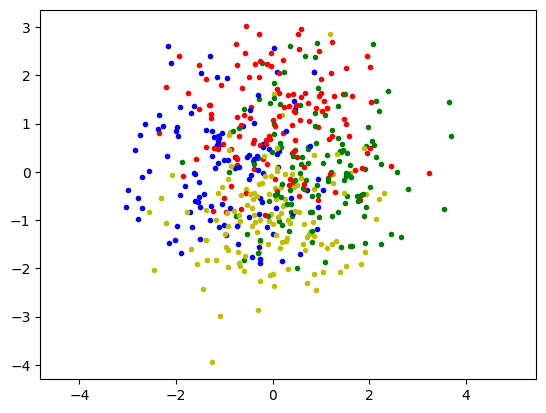

In [14]:
np.random.seed(12345)
data_size = 500

def sample_datapoints(sample_size):
    color_dict = {0:'r', 1:'g', 2:'b', 3:'y'}
    
    means = np.array([[0, 1], [1, 0], [-1, 0], [0, -1]])
    covs = np.tile(np.identity(2), (4, 1, 1))
    pts = np.empty((sample_size, 2))
    
    for i in range(sample_size):
        r = np.random.uniform()
        k = (int)(r // 0.25)
        pts[i] = np.random.multivariate_normal(means[k], covs[k])
        plt.plot(pts[i, 0], pts[i, 1], '.', color = color_dict[k])
    
    
    plt.axis('equal')
    plt.show()
    
    return pts
    

data_points= sample_datapoints(data_size)

__(b)__ Below, we have implemented the necessary functions for the implementation of the K-means algorithm. <br>
* *distance*: Calculates the euclidean distance between two vectors.
* *initialize_centroids*: Randomly selects K data points among the generated data and these data points are used for the initialization of the centroids.
* *update_memberships*: Updates cluster memberships of our data points.
* *update_centroids*: Updates the coordinates of the centroids.
* *k_means*: Classifies the data points in K clusters using Lloyd's algorithm. 
* *plot_clusters*: Plots clusters after the k-means algorithm converged.

In [15]:
def distance(centroid, point):
    return np.linalg.norm(point - centroid)


def initialize_centroids():
    random_indices = np.random.randint(0, data_size, size=K)
    centroids = np.empty((K, 2))
    
    for i in range(K):
        centroids[i] = data_points[random_indices[i]]
    
    return centroids


def update_memberships():
    for i in range(data_size):
        min_distance = 10000   # random huge number
        idx = -1 
        for j in range(K):
            dist = distance(centroids[j], data_points[i])
            if dist < min_distance:
                min_distance = dist
                idx = j
                
        for j in range(K):
            if j == idx:
                M[i, j] = 1
            else: 
                M[i, j] = 0
                
                      

def update_centroids():
    for i in range(K):
        cluster_size = 0
        cluster_sum = 0
        
        for j in range(data_size):
            if M[j, i] == 1:
                cluster_size += 1
                cluster_sum += data_points[j]
                
        centroids[i] = cluster_sum / cluster_size
    
    
def k_means():
    iterations = 0
    while iterations < 20:
        update_memberships()
        update_centroids()
        iterations += 1

        
def plot_clusters():
    color_dict = {0:'r', 1:'g', 2:'b', 3:'y'}
    
    for i in range(data_size):
        for j in range(K):
            if M[i, j] == 1:
                plt.plot(data_points[i, 0], data_points[i, 1], '.', color = color_dict[j])
    
    plt.axis('equal')
    plt.show()
    
    

__(b)__ k-means algorithm could not correctly cluster the different components of the mixture. <br>
Because, the original clusters overlap too much, which prevents the k-means algorithm from classifying correctly.

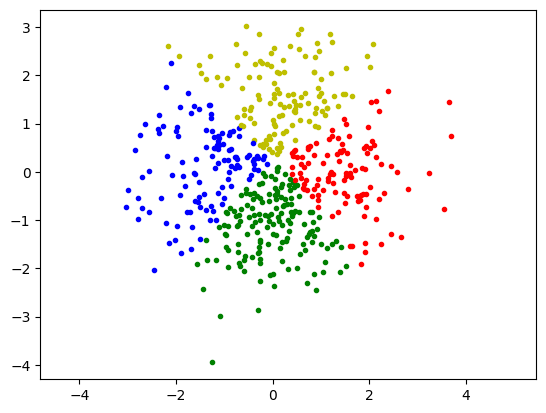

In [16]:
np.random.seed(12345)
K = 4                                       # number of clusters
M = np.zeros((data_size, K), dtype = bool)  # membership matrix
centroids = initialize_centroids()          # centroid array
k_means()                                   # k-means algorithm
plot_clusters()                             # plotting clusters